## Import Libraries & Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *

In [46]:
df = pd.read_csv("Conspan July 24.csv")

In [4]:
df.head()

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,...,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,...,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research & Development,7,4.0,2.0,Female,4,1,2,...,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research & Development,9,3.0,4.0,Male,2,3,2,...,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,...,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research & Development,17,3.0,4.0,Male,3,2,4,...,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Employee ID               1201 non-null   int64  
 1   Age                       1199 non-null   float64
 2   Department                1201 non-null   object 
 3   DistanceFromHome          1201 non-null   int64  
 4   Education                 1198 non-null   float64
 5   EnvironmentSatisfaction   1199 non-null   float64
 6   Gender                    1201 non-null   object 
 7   JobInvolvement            1201 non-null   int64  
 8   JobLevel                  1201 non-null   int64  
 9   JobRotation               1201 non-null   int64  
 10  FeedbackFromManager       1200 non-null   object 
 11  Mentoring                 1200 non-null   object 
 12  Autonomy                  1200 non-null   object 
 13  JobRole                   1200 non-null   object 
 14  MonthlyI

## Data Quality Checks

In [6]:
def summarize_schema(df: pd.DataFrame) -> pd.DataFrame:
    info = []
    for col in df.columns:
        dtype = df[col].dtype
        inferred = pd.api.types.infer_dtype(df[col], skipna=True)
        info.append({
            'column': col,
            'dtype': str(dtype),
            'inferred': inferred,
            'non_null_count': int(df[col].notna().sum()),
            'null_count': int(df[col].isna().sum()),
            'null_pct': float(df[col].isna().mean()*100),
            'n_unique': int(df[col].nunique(dropna=True))
        })
    return pd.DataFrame(info).sort_values(['dtype','column']).reset_index(drop=True)

In [7]:
def missingness_report(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().mean().sort_values(ascending=False)*100
    return miss.to_frame('missing_pct').reset_index().rename(columns={'index': 'column'})

In [8]:
def duplicate_report(df: pd.DataFrame) -> pd.DataFrame:
    dup_rows = df.duplicated(keep=False)
    n_dups = int(dup_rows.sum())
    return pd.DataFrame({'metric':['duplicate_rows'], 'value':[n_dups]})

In [9]:
def numeric_outlier_summary(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns
    rows = []
    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            rows.append({'column': col, 'lower_bound': np.nan, 'upper_bound': np.nan,
                         'outlier_count': 0, 'outlier_pct': 0.0})
            continue
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        mask = (df[col] < lower) | (df[col] > upper)
        rows.append({
            'column': col,
            'lower_bound': float(lower),
            'upper_bound': float(upper),
            'outlier_count': int(mask.sum()),
            'outlier_pct': float(mask.mean()*100)
        })
    return pd.DataFrame(rows)

In [10]:
def detect_numeric_strings(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        if df[col].dtype == 'object':
            s = df[col].astype(str).str.strip()
            s_repl = s.replace({'': np.nan, 'nan': np.nan, 'None': np.nan})
            numeric_like = s_repl.str.match(r'^[-+]?\\d+(\\.\\d+)?$')
            n_numeric_like = int(numeric_like.fillna(False).sum())
            rows.append({
                'column': col,
                'object_numeric_like': n_numeric_like,
                'object_total': int(len(s)),
                'numeric_like_pct': float(numeric_like.mean(skipna=True)*100 if numeric_like.notna().any() else 0.0)
            })
    return pd.DataFrame(rows)

In [11]:
def string_quality(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.select_dtypes(include=['object']).columns:
        s = df[col].astype(str)
        lens = s.str.len()
        leading_ws = s.str.match(r'^\\s').sum()
        trailing_ws = s.str.match(r'.*\\s$').sum()
        non_printable = s.str.contains(r'[^\\x20-\\x7E\\n\\r\\t]', regex=True).sum()
        rows.append({
            'column': col,
            'min_len': int(lens.min()),
            'p5_len': float(lens.quantile(0.05)),
            'median_len': float(lens.median()),
            'p95_len': float(lens.quantile(0.95)),
            'max_len': int(lens.max()),
            'leading_ws_count': int(leading_ws),
            'trailing_ws_count': int(trailing_ws),
            'non_printable_count': int(non_printable)
        })
    return pd.DataFrame(rows)

In [12]:
def cardinality_report(df: pd.DataFrame, high_card_threshold: int = 50) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        nunique = int(df[col].nunique(dropna=True))
        rows.append({'column': col, 'unique': nunique, 'high_cardinality': bool(nunique > high_card_threshold)})
    return pd.DataFrame(rows).sort_values('unique', ascending=False).reset_index(drop=True)

In [13]:
def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number])
    if num.empty:
        return pd.DataFrame()
    desc = num.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
    desc['missing_pct'] = 100*(1 - desc['count']/len(df))
    return desc.reset_index().rename(columns={'index':'column'})

In [14]:
schema = summarize_schema(df)
missing = missingness_report(df)
dups = duplicate_report(df)
outliers = numeric_outlier_summary(df)
numstr = detect_numeric_strings(df)
strq = string_quality(df)
card = cardinality_report(df)
numsum = numeric_summary(df)

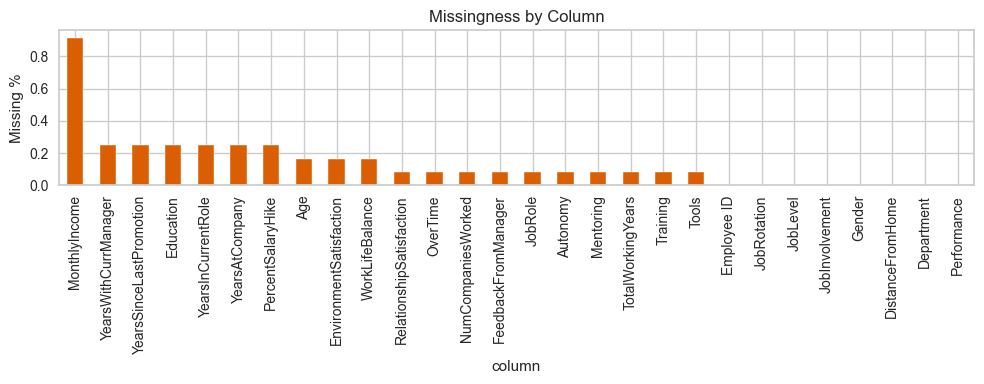

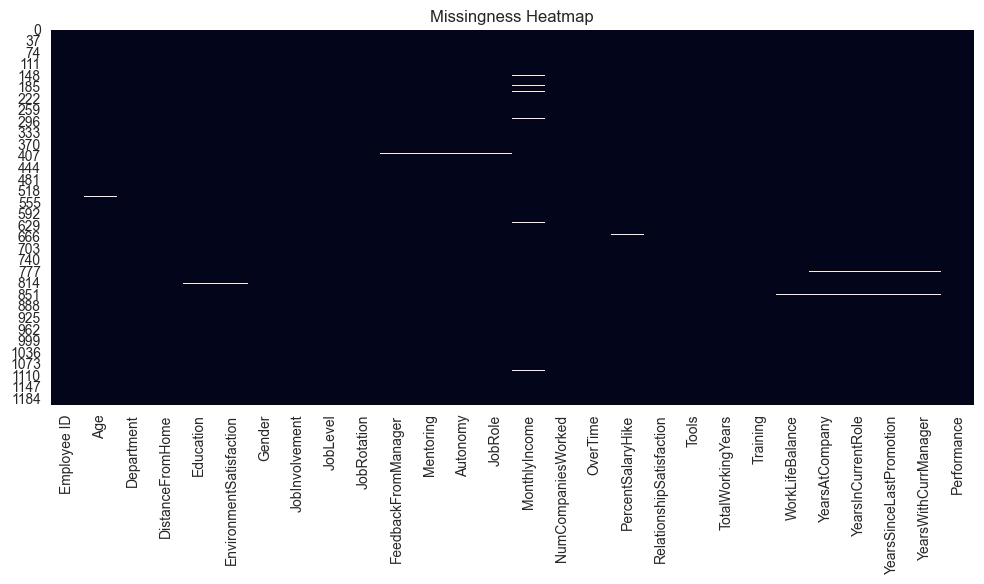

In [15]:
plt.figure(figsize=(10,4))
missing.set_index('column')['missing_pct'].plot(kind='bar', color='#d95f02')
plt.ylabel('Missing %')
plt.title('Missingness by Column')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missingness Heatmap')
plt.tight_layout()
plt.show()

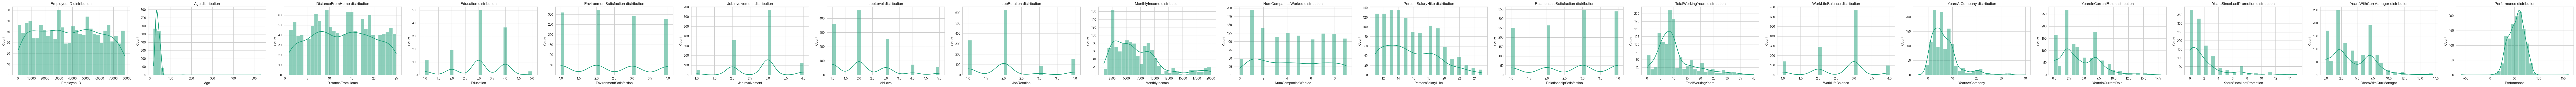

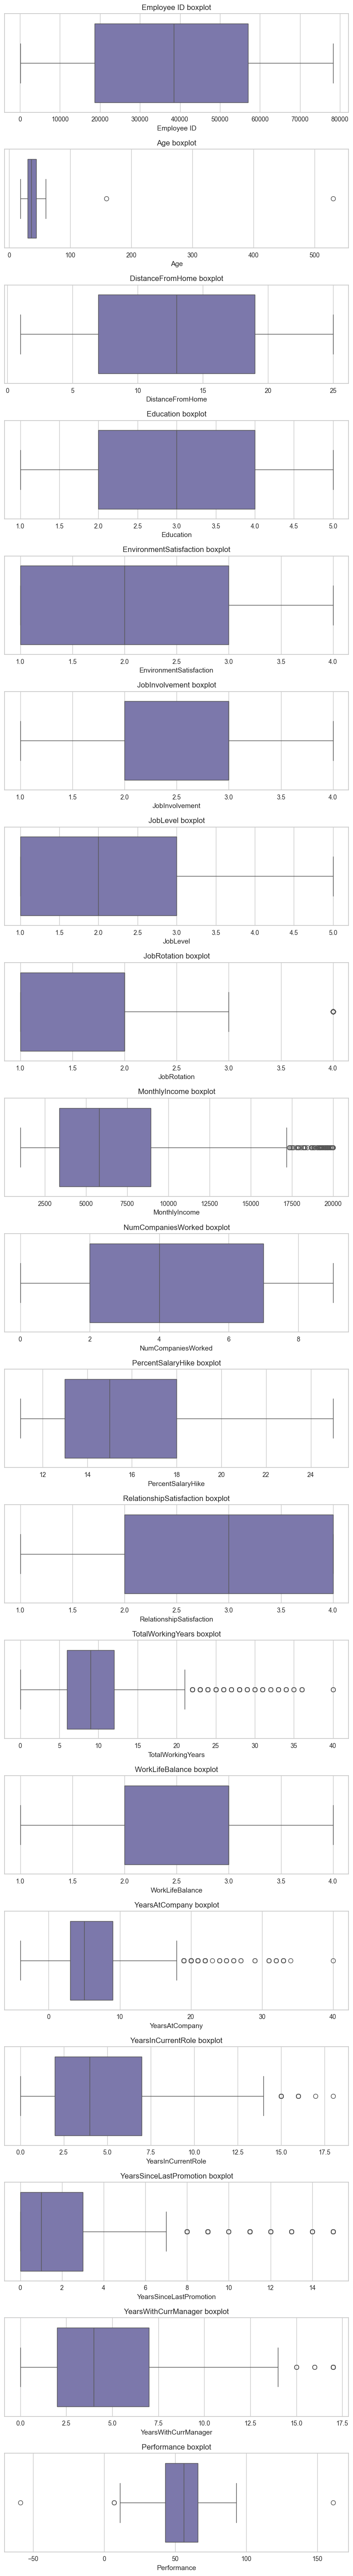

In [16]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    fig, axes = plt.subplots(1, len(num_cols), figsize=(6*len(num_cols),4))
    if len(num_cols) == 1: axes = [axes]
    for ax, col in zip(axes, num_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=ax, color='#1b9e77')
        ax.set_title(f'{col} distribution')
    plt.tight_layout(); plt.show()

    fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 3*len(num_cols)))
    if len(num_cols) == 1: axes = [axes]
    for ax, col in zip(axes, num_cols):
        sns.boxplot(x=df[col], ax=ax, color='#7570b3')
        ax.set_title(f'{col} boxplot')
    plt.tight_layout()
    plt.show()

## Feature Importance mapping

In [17]:
reg_setup = setup(
    data=df,
    target='Performance',
    session_id=42,
    train_size=0.8,
    normalize=False,
    imputation_type='simple',
    categorical_features=None,
    numeric_features=None,
    ignore_features=['Employee ID'],
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fold=5,
    use_gpu=True,
    verbose=False
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no m

In [18]:
best = compare_models(n_select=1)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:44:48
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6.3797,84.3647,9.0863,0.6639,0.1928,0.1431,0.3420
et,Extra Trees Regressor,6.4639,88.0019,9.2873,0.6484,0.1964,0.1435,0.3320
gbr,Gradient Boosting Regressor,6.5927,91.3207,9.4489,0.6369,0.1979,0.1488,0.3540
ada,AdaBoost Regressor,8.3425,120.5733,10.9345,0.5138,0.2263,0.1853,0.2300
br,Bayesian Ridge,8.1363,124.5387,11.0865,0.4989,0.2313,0.1834,0.1240
ridge,Ridge Regression,8.1758,125.4522,11.1282,0.4951,0.2324,0.1837,0.1280
lr,Linear Regression,8.2253,127.4822,11.2174,0.4872,0.2347,0.1845,0.1540
llar,Lasso Least Angle Regression,8.3616,138.3344,11.7018,0.4429,0.2460,0.1936,0.1120
lasso,Lasso Regression,8.3616,138.3344,11.7018,0.4429,0.2460,0.1936,0.1540
dt,Decision Tree Regressor,8.5635,152.6281,12.2902,0.3829,0.2527,0.1866,0.1480


In [19]:
best_tuned = tune_model(best, optimize='R2')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:45:13
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3948,69.9190,8.3618,0.6896,0.1800,0.1385
1,6.1336,70.4505,8.3935,0.6779,0.1970,0.1423
2,7.6535,115.2542,10.7356,0.5914,0.2643,0.2058
3,7.2811,133.5961,11.5584,0.5268,0.1960,0.1413
4,6.0517,67.4555,8.2131,0.6973,0.1751,0.1332
Mean,6.7029,91.3351,9.4525,0.6366,0.2025,0.1523
Std,0.6452,27.6520,1.4091,0.0668,0.0321,0.0270


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [20]:
final_model = finalize_model(best_tuned)

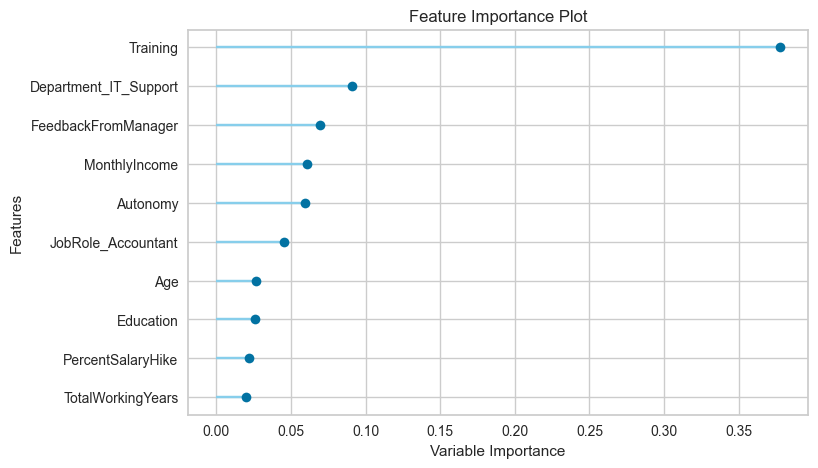

In [21]:
plot_model(final_model, plot='feature')

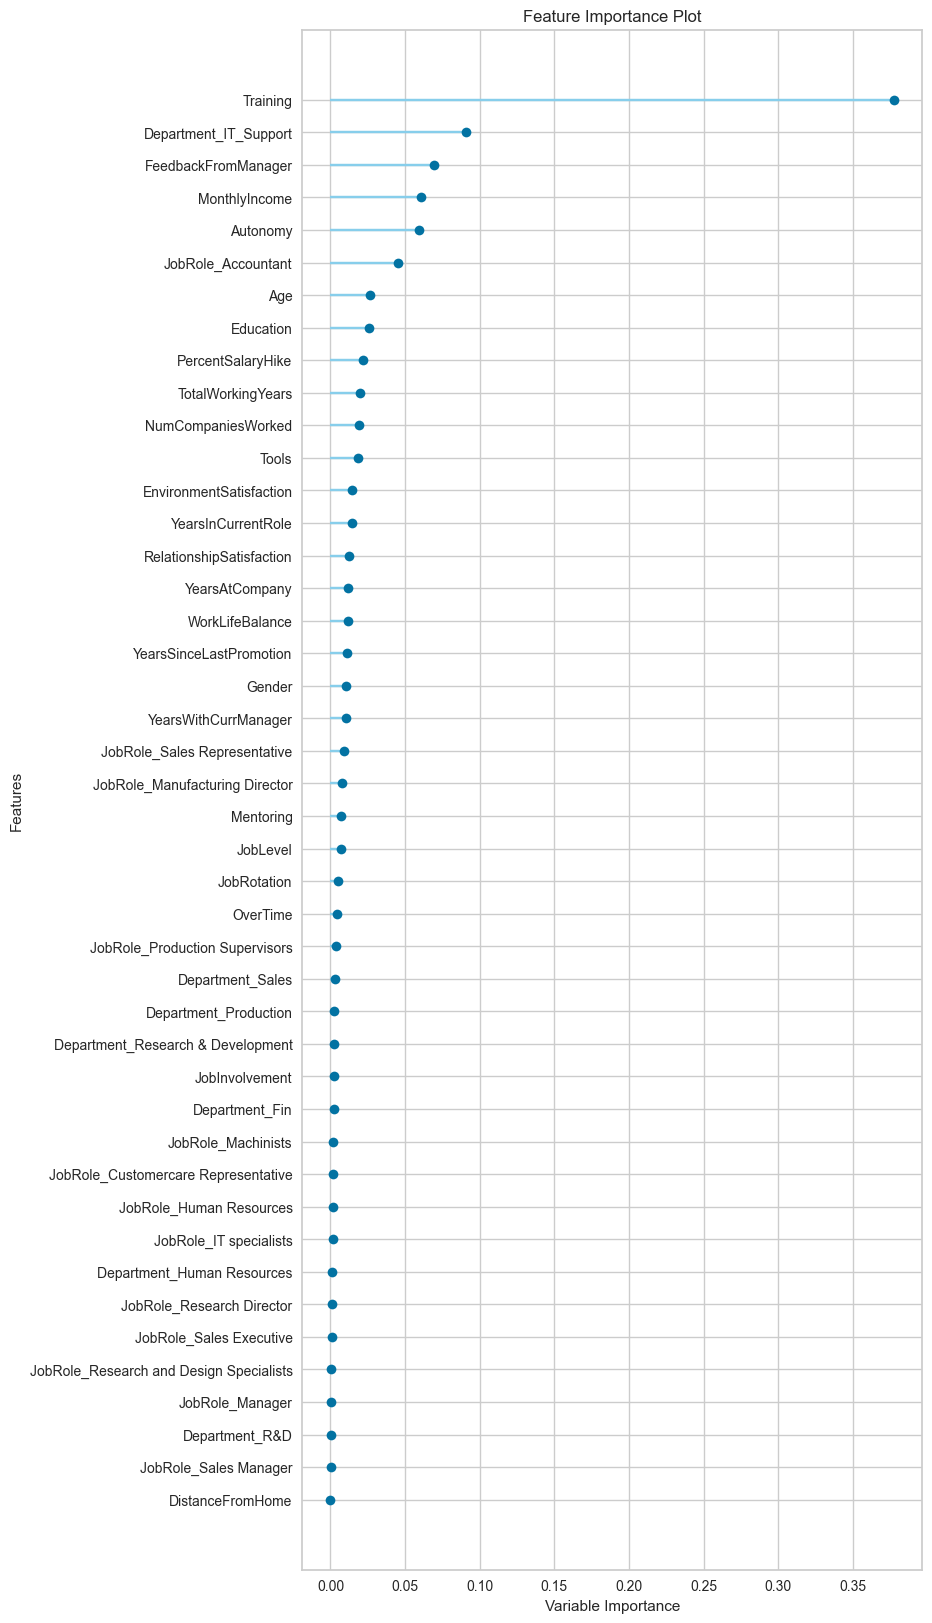

In [22]:
plot_model(final_model, plot='feature_all')

## Data Cleaning using Data Dict

In [35]:
data_dict = {
    "EmployeeID": {"type": "int"},
    "Age": {"min": 18, "max": 60},
    "Department": {"allowed": ["Human Resources", "IT Support", "Production","Research and Development", "Finance", "Sales"]},
    "DistanceFromHome": {"min": 1, "max": 25},
    "Education": {"min": 1, "max": 5},
    "EnvironmentSatisfaction": {"min": 1, "max": 4},
    "Gender": {"allowed": ["Male", "Female"]},
    "JobInvolvement": {"min": 1, "max": 4},
    "JobLevel": {"min": 1, "max": 5},
    "JobRole": {"type": "string"},
    "JobRotation": {"min": 1, "max": 4},
    "FeedbackFromManager": {"allowed": ["H", "L"]},
    "Mentoring": {"allowed": ["Y", "N"]},
    "MonthlyIncome": {"min": 0, "max": None},
    "NumCompaniesWorked": {"min": 0, "max": None},
    "OverTime": {"allowed": ["Yes", "No"]},
    "Performance": {"min": 0, "max": 100},
    "PercentSalaryHike": {"min": 0, "max": 100},
    "RelationshipSatisfaction": {"min": 1, "max": 4},
    "TotalWorkingYears": {"min": 0, "max": None},
    "WorkLifeBalance": {"min": 1, "max": 4},
    "YearsAtCompany": {"min": 0, "max": None},
    "YearsInCurrentRole": {"min": 0, "max": None},
    "YearsSinceLastPromotion": {"min": 0, "max": None},
    "YearsWithCurrManager": {"min": 0, "max": None},
    "Autonomy": {"allowed": ["H", "L"]},
    "Tools": {"allowed": ["L", "H"]},
    "Training": {"allowed": ["Y", "N"]}
}

In [48]:
def validate_dataframe(df, data_dict):
    invalid_flags = pd.DataFrame(False, index=df.index, columns=df.columns)

    for col, rules in data_dict.items():
        if col not in df.columns:
            continue

        if "min" in rules or "max" in rules:
            if "min" in rules and rules["min"] is not None:
                invalid_flags[col] |= df[col] < rules["min"]
            if "max" in rules and rules["max"] is not None:
                invalid_flags[col] |= df[col] > rules["max"]

        if "allowed" in rules:
            invalid_flags[col] |= ~df[col].isin(rules["allowed"])

    return invalid_flags

In [49]:
invalids = validate_dataframe(df, data_dict)
invalids

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,...,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1197,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1198,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1199,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
rows_with_issues = df[invalids.any(axis=1)]
rows_with_issues

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,...,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,...,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research & Development,7,4.0,2.0,Female,4,1,2,...,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research & Development,9,3.0,4.0,Male,2,3,2,...,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,...,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research & Development,17,3.0,4.0,Male,3,2,4,...,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,77703,38.0,Human Resources,6,3.0,1.0,Male,3,1,2,...,4.0,H,13.0,Y,3.0,11.0,10.0,3.0,8.0,70
1197,77743,39.0,Research & Development,10,1.0,4.0,Female,2,4,2,...,3.0,L,21.0,Y,3.0,21.0,6.0,11.0,8.0,60
1198,78090,56.0,Research & Development,20,3.0,1.0,Female,3,1,1,...,2.0,L,18.0,N,3.0,5.0,4.0,0.0,3.0,35
1199,78175,38.0,Sales,15,2.0,2.0,Female,3,2,2,...,4.0,L,11.0,Y,3.0,7.0,7.0,1.0,7.0,73


In [51]:
def summarize_invalids(df, invalid_flags):
    summary = {}
    for col in df.columns:
        if col in invalid_flags.columns:
            invalid_count = invalid_flags[col].sum()
            if invalid_count > 0:
                summary[col] = {
                    "invalid_count": invalid_count,
                    "total_rows": len(df),
                    "percent_invalid": round((invalid_count / len(df)) * 100, 2)
                }
    return pd.DataFrame(summary).T.sort_values("percent_invalid", ascending=False)

In [52]:
invalids = validate_dataframe(df, data_dict)
summary = summarize_invalids(df, invalids)
summary

,invalid_count,total_rows,percent_invalid
Autonomy,1201.0,1201.0,100.00
Department,489.0,1201.0,40.72
Age,2.0,1201.0,0.17
Performance,2.0,1201.0,0.17
FeedbackFromManager,1.0,1201.0,0.08
Mentoring,1.0,1201.0,0.08
OverTime,1.0,1201.0,0.08
Tools,1.0,1201.0,0.08
Training,1.0,1201.0,0.08
YearsAtCompany,1.0,1201.0,0.08


In [53]:
df.head()

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,...,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,...,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research & Development,7,4.0,2.0,Female,4,1,2,...,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research & Development,9,3.0,4.0,Male,2,3,2,...,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,...,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research & Development,17,3.0,4.0,Male,3,2,4,...,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67


Autonomy has "Y/N" values per the dataset, but the data dictionary specifies "H/L" values. Discuss w/ team.

In [54]:
df.loc[~df["Department"].isin(data_dict["Department"]["allowed"]), "Department"].unique()

array(['Research & Development', 'IT_Support', 'R&D', 'Fin'], dtype=object)

In [43]:
data_dict["Department"]["allowed"]

['Human Resources',
 'IT Support',
 'Production',
 'Research and Development',
 'Finance',
 'Sales']

Invalid departments are just abbreviations or minor typos. Can be replaced.

In [44]:
dept_corrections = {
    "Research & Development": "Research and Development",
    "IT_Support": "IT Support",
    "R&D": "Research and Development",
    "Fin": "Finance"
}

df["Department"] = df["Department"].replace(dept_corrections)

In [45]:
invalids = validate_dataframe(df, data_dict)
summary = summarize_invalids(df, invalids)
summary

,invalid_count,total_rows,percent_invalid
Autonomy,1201.0,1201.0,100.00
Age,2.0,1201.0,0.17
Performance,2.0,1201.0,0.17
FeedbackFromManager,1.0,1201.0,0.08
Mentoring,1.0,1201.0,0.08
OverTime,1.0,1201.0,0.08
Tools,1.0,1201.0,0.08
Training,1.0,1201.0,0.08
YearsAtCompany,1.0,1201.0,0.08
